# K-Shape Time Series Clustering 

This algorithm is designed for clustering time series data based on their shape, it can deal with time series that contain shift and differnece in magnitude.

For detailed information please refer to the original article:

<cite>Paparrizos, John, and Luis Gravano. "k-shape: Efficient and accurate clustering of time series." Proceedings of the 2015 ACM SIGMOD International Conference on Management of Data. ACM, 2015.</cite>

http://web2.cs.columbia.edu/~gravano/Papers/2015/sigmod2015.pdf

#### Necessery imports

In [13]:
import sagemaker as sage
import boto3
import botocore

from uuid import uuid4
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from itertools import imap
from functools import partial
import seaborn
from scipy.stats import zscore
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Fetch And Pre-Process The ECG200 Data Set

#### Download the data set

In [2]:
!wget http://timeseriesclassification.com/Downloads/ECG200.zip -O /tmp/ECG200.zip

--2018-11-01 15:26:34--  http://timeseriesclassification.com/Downloads/ECG200.zip
Resolving timeseriesclassification.com (timeseriesclassification.com)... 109.123.71.232
Connecting to timeseriesclassification.com (timeseriesclassification.com)|109.123.71.232|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202788 (198K) [application/zip]
Saving to: ‘/tmp/ECG200.zip’

/tmp/ECG200.zip     100%[===================>] 198.04K   263KB/s    in 0.8s    

2018-11-01 15:26:36 (263 KB/s) - ‘/tmp/ECG200.zip’ saved [202788/202788]



#### Convert train to CSV format

In [3]:
!mkdir -p ecg200
!unzip /tmp/ECG200.zip -d ecg200
!cat ecg200/ECG200_TRAIN.txt | sed -E "s/^\s+//g"  | sed -E 's/\s+/,/g' | sed -E "s/^(-?[0-9])\.0000000e\+00/\1/g" > ecg200/train.txt

Archive:  /tmp/ECG200.zip
  inflating: ecg200/ECG200.txt       
  inflating: ecg200/ECG200_TEST.arff  
  inflating: ecg200/ECG200_TEST.txt  
  inflating: ecg200/ECG200_TRAIN.arff  
  inflating: ecg200/ECG200_TRAIN.txt  


#### Upload train to S3

In [4]:
my_bucket = "spotad.sagemaker.poc"

sagemaker_session = sage.Session()
train_file = sagemaker_session.upload_data('ecg200/train.txt', my_bucket, "ecg200-test/data")

## Define and Run a Training Job

#### We will cluster the data into two clusters (k=2) and ignore the first column in the csv (label_size=1)

In [5]:
role = sage.get_execution_role()

job_name = 'k-shape-' + str(uuid4())
print("Training job", job_name)

image = '518447545674.dkr.ecr.us-east-2.amazonaws.com/k-shape-clustering:latest'

output_location = 's3://{}/ecg200-test/model'.format(my_bucket)
print('Model will be uploaded to: {}'.format(output_location))

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": output_location
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m5.large",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "k": "2",
        "label_size": "1"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": train_file,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }
    ]
}

sagemaker = boto3.client('sagemaker')

sagemaker.create_training_job(**create_training_params)

status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)

try:
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
finally:
    status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print("Training job ended with status: " + status)
    if status == 'Failed':
        message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Training job failed')

('Training job', 'k-shape-c5d1b34b-4eb1-46b5-b996-602920ab8a88')
Model will be uploaded to: s3://spotad.sagemaker.poc/ecg200-test/model
InProgress
Training job ended with status: Completed


## Inspect the Clusters Produced by the Training Job

#### Download the produced model file 

In [6]:
s3 = boto3.resource('s3')

try:
    s3.Bucket(my_bucket).download_file('ecg200-test/model/{}/output/model.tar.gz'.format(job_name), 'model.tar.gz')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [7]:
!mkdir -p model
!tar -zxvf model.tar.gz -C model

centroids


#### Load the centroids from the model file

In [8]:
split_by_comma = lambda s: str.split(s, ',')

centroids = list()
with open('model/centroids', 'r') as f:
    for record in imap(split_by_comma, imap(str.strip, f)):
        centroids.append(np.array(map(float,record)))

#### Plot the shapes of the clusters found 

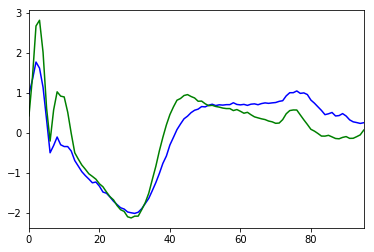

In [14]:
seaborn.tsplot(centroids[0], color='blue')  
seaborn.tsplot(centroids[1], color='green')

# Assign time series to clusters and find their optimal shift

#### Define a sage maker model

In [15]:
model_name= 'k-shape-' + str(uuid4())
job_info = sagemaker.describe_training_job(TrainingJobName=job_name)
model_s3_file = job_info['ModelArtifacts']['S3ModelArtifacts']

primary_container = {
    'Image': image,
    'ModelDataUrl': model_s3_file,
}

model = sagemaker.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print model

{u'ModelArn': u'arn:aws:sagemaker:us-east-2:518447545674:model/k-shape-ac55183d-2b49-4519-bbe8-d034ad9ce82a', 'ResponseMetadata': {'RetryAttempts': 0, 'HTTPStatusCode': 200, 'RequestId': 'd9988098-868f-4a59-a962-bfa10861f50f', 'HTTPHeaders': {'x-amzn-requestid': 'd9988098-868f-4a59-a962-bfa10861f50f', 'date': 'Thu, 01 Nov 2018 15:36:54 GMT', 'content-length': '106', 'content-type': 'application/x-amz-json-1.1'}}}


#### Define and run a Batch Transform Job

* We specify that we want to ignore the first column by specifying the content_type to be 'text/csv;label_size=1'

In [16]:
output_location = 's3://{}/ecg200-test/prediction/'.format(my_bucket)

transformer =sage.transformer.Transformer(
    base_transform_job_name='Batch-Transform',
    model_name=model_name,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=output_location
    )

transformer.transform(train_file, content_type='text/csv;label_size=1', split_type='Line')
transformer.wait()

INFO:sagemaker:Creating transform job with name: Batch-Transform-2018-11-01-15-36-58-103


.......................!


#### Download the prediction file 

* The file produced is in CSV format with 3 columns: 
  - cluster_id: the cluster id the time series belongs to
  - distance: the distance to the assigned clusters cetroid
  - shift: the optimal shift used to match the time series to the centroid

In [17]:
try:
    s3.Bucket(my_bucket).download_file('ecg200-test/prediction/train.txt.out'.format(job_name), 'ecg200/prediction.txt')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

#### Load prediction the timeseries

In [18]:
Prediction = namedtuple("Prediction",["cluster_id", "distance", "shift"])
Example = namedtuple("Example",["label", "time_series"])

train = list()

with open('ecg200/train.txt', 'r') as f:
    for record in imap(split_by_comma,imap(str.strip, f)):
        train.append(Example(record[0], np.array(map(float,record[1:]))))
        
prediction = list()
with open('ecg200/prediction.txt', 'r') as f:
    for record in imap(split_by_comma,imap(str.strip, f)):
        prediction.append(Prediction(int(record[0]), float(record[1]), int(record[2])))

# example
print prediction[0]

Prediction(cluster_id=0, distance=0.08424051088966211, shift=-4)


#### Plot the clusters
- Since the centroids are Z normalized we do the same to the original time series to align them on the same plot

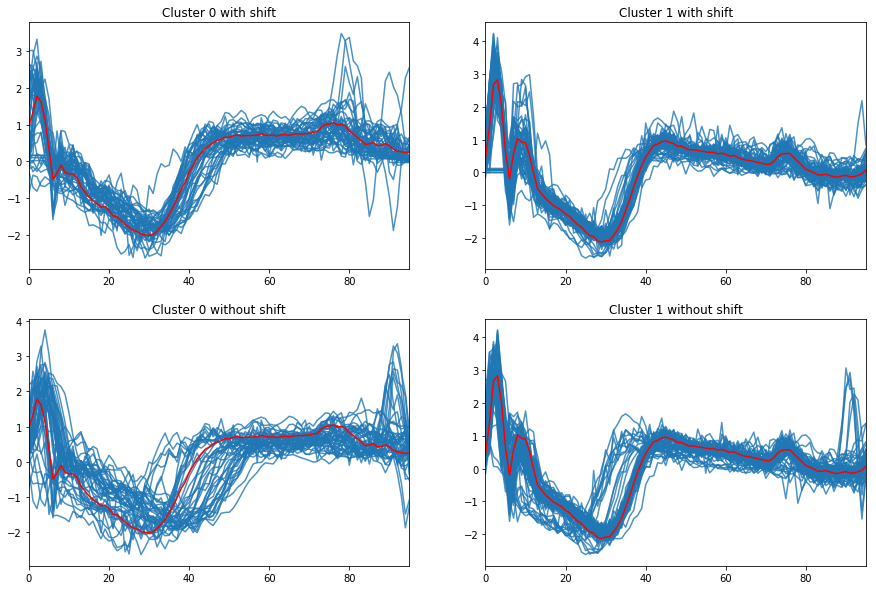

In [19]:
f, ((ax0, ax1), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

def shift(x, amount):
    if(amount >= 0):
        return np.pad(x, (amount,0), mode='constant')[:len(x)]
    else:
        return np.pad(x, (0, -amount), mode='constant')[-amount:]

for e,p in zip(train, prediction):
    if(p.cluster_id == 0):
        seaborn.tsplot(data=zscore(shift(e.time_series, p.shift)), ax=ax0, alpha=0.8)  
    else:
        seaborn.tsplot(data=zscore(shift(e.time_series, p.shift)), ax=ax1, alpha=0.8)
        
    if(p.cluster_id == 0):
        seaborn.tsplot(data=zscore(e.time_series), ax=ax3, alpha=0.8)  
    else:
        seaborn.tsplot(data=zscore(e.time_series), ax=ax4, alpha=0.8)
    
ax0.set_title('Cluster 0 with shift')
ax1.set_title('Cluster 1 with shift')
ax3.set_title('Cluster 0 without shift')
ax4.set_title('Cluster 1 without shift')
    
seaborn.tsplot(data=zscore(centroids[0]), ax=ax0, color='red') 
seaborn.tsplot(data=zscore(centroids[1]), ax=ax1, color='red')
seaborn.tsplot(data=zscore(centroids[0]), ax=ax3, color='red') 
seaborn.tsplot(data=zscore(centroids[1]), ax=ax4, color='red')
    

# Cleanup

In [20]:
!rm -rf ecg200
!rm -rf model
!rm -f model.tar.gz

# Final Notes

* When using prediction through an endpoint both content_type and accept can use: text/csv, application/json or application/jsonline in the formats specfied in https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-inference.html]